In [2]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
from keras.applications import vgg19
from keras import backend as K
import os
import matplotlib.pyplot as plt
from PIL import Image

Using TensorFlow backend.


## Funkcja sluzaca do preprocessingu obrazka

In [3]:
def preprocess_image(image_path, img_nrows, img_ncols):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

## Funkcja sluzaca do deprocessingu obrazka w celu wyswietlenia go

In [4]:
def deprocess_image(x, img_nrows, img_ncols):
    x = x.reshape((img_nrows, img_ncols, 3))
        
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

## Funkcja obliczajaca strate stylu

In [5]:
# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination, img_nrows, img_ncols):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

## Funkcja obliczajaca strate zawartosci

In [6]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

## Funkcja obliczajaca strate wariacji 

In [7]:
# designed to keep the generated image locally coherent
def total_variation_loss(x, img_nrows, img_ncols):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Funkcja obliczajaca wartosc straty i gradient dla danego inputu x

In [8]:
def eval_loss_and_grads(x, img_nrows, img_ncols, f_outputs):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

## Pomocnicza klasa przechowujaca strate i gradient

In [9]:
# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):

    def __init__(self, img_nrows, img_ncols, f_outputs):
        self.loss_value = None
        self.grads_values = None
        self.img_nrows = img_nrows
        self.img_ncols = img_ncols
        self.f_outputs = f_outputs

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x, self.img_nrows, self.img_ncols, self.f_outputs)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

## Klasa odpowiedzialna za wykonanie transferu stylu

In [10]:
class StyleTransferer:
    
    def __init__(self, 
                base_image_path,
                style_reference_image_path,
                iterations = 5,
                total_variation_weight = 1.0,
                style_weight = 1.0,
                content_weight = 0.25,
                img_nrows = 100):
        
        # count picture haight to maintain aspect ratio
        width, height = load_img(base_image_path).size
        img_ncols = int(width * img_nrows / height)
        
        self.base_image_path = base_image_path
        self.iterations = iterations
        self.img_nrows = img_nrows
        self.img_ncols = img_ncols
        self.directory = './results/' + base_image_path.split('.')[0] + \
            '_to_' + style_reference_image_path.split('.')[0] + '/'
        
        # create directory for results
        if not os.path.exists(self.directory):
                os.makedirs(self.directory)
        
        # get tensor representations of our images
        base_image = K.variable(preprocess_image(base_image_path, img_nrows, img_ncols))
        style_reference_image = K.variable(preprocess_image(style_reference_image_path, img_nrows, img_ncols))
        
        # get tensor to contain our generated image
        combination_image = K.placeholder((1, img_nrows, img_ncols, 3))
        
        # combine the 3 tensors into a single one
        input_tensor = K.concatenate([base_image, style_reference_image, combination_image], axis=0)
        
        # build the VGG19 network with our 3 images as input, the model will be loaded with pre-trained weights
        model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)
        print('Model loaded.')
        
        # get the symbolic outputs of each "key" layer (we gave them unique names).
        outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
        
        # get content_loss Keras variable
        layer_features = outputs_dict['block5_conv2']
        base_image_features = layer_features[0, :, :, :]
        combination_features = layer_features[2, :, :, :]
        content_loss_variable = content_loss(base_image_features, combination_features)
        
        # get style_loss Keras variable
        feature_layers = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1','block5_conv1']
        style_loss_variable = 0
        for layer_name in feature_layers:
            layer_features = outputs_dict[layer_name]
            style_reference_features = layer_features[1, :, :, :]
            combination_features = layer_features[2, :, :, :]
            sl = style_loss(style_reference_features, combination_features, img_nrows, img_ncols)
            # add portion of syle loss
            style_loss_variable += sl / len(feature_layers)
            
        # get variation_loss Keras variable
        variation_loss_variable = total_variation_loss(combination_image, img_nrows, img_ncols)
        
        # combine separate loss variables into a single one
        total_loss_variable = K.variable(0.0)
        total_loss_variable += content_weight * content_loss_variable
        total_loss_variable += style_weight * style_loss_variable
        total_loss_variable += total_variation_weight * variation_loss_variable
        
        # get the gradients of the generated image with respect to the loss
        grads = K.gradients(total_loss_variable, combination_image)

        outputs = [total_loss_variable]
        if isinstance(grads, (list, tuple)):
            outputs += grads
        else:
            outputs.append(grads)

        # create Keras function calculating total loss and gradient of loss function
        self.f_outputs = K.function([combination_image], outputs)
        
        # create Keras function calculating all the loss variables
        losses_outputs = [total_loss_variable, content_loss_variable, style_loss_variable, variation_loss_variable]
        self.f_losses = K.function([combination_image], losses_outputs)
        
        # initializing evaluator used during learning process
        self.evaluator = Evaluator(self.img_nrows, self.img_ncols, self.f_outputs)
        
    def runTransfer(self):
        x = preprocess_image(self.base_image_path, self.img_nrows, self.img_ncols)

        generated_images = []
        counted_losses = []
        
        for i in range(self.iterations):
            start_time = time.time()
            print('Started iteration', i + 1)
            
            # minimize total loss variable using its gradient
            x, min_val, info = fmin_l_bfgs_b(self.evaluator.loss, x.flatten(), fprime=self.evaluator.grads, maxfun=20)
            print('Current value of combined loss:', min_val)
            
            generated_images.append(deprocess_image(x.copy(), self.img_nrows, self.img_ncols))
            counted_losses.append(self.f_losses([x.reshape((1, self.img_nrows, self.img_ncols, 3))]))
            
            # save image
            save_img(self.directory + 'At_iteration_' + str(i + 1) + '.png', generated_images[-1])
            
            end_time = time.time()
            print('Iteration', i + 1, 'completed in', end_time - start_time)
    
        return generated_images, counted_losses

## Zmienne mowiace same za siebie

In [11]:
base_image_path = 'pictures/sansa.jpg'
style_image_path = 'pictures/kosmos.jpg'
generated_picture_height = 200
number_of_iterations_of_learning = 4

## Pierwszy transfer stylu - waga stylu znacznie wieksza od wagi zawartosci

In [11]:
first_transferer = StyleTransferer(iterations=number_of_iterations_of_learning, 
                             img_nrows=generated_picture_height, 
                             base_image_path=base_image_path, 
                             style_reference_image_path=style_image_path,
                             style_weight=15,
                             content_weight=5)

first_images, first_losses = first_transferer.runTransfer()

Instructions for updating:
Colocations handled automatically by placer.
Model loaded.
Started iteration 1
Current value of combined loss: 144203430000.0
Iteration 1 completed in 103.43573570251465
Started iteration 2
Current value of combined loss: 67334340000.0
Iteration 2 completed in 102.66190123558044
Started iteration 3
Current value of combined loss: 41499808000.0
Iteration 3 completed in 102.87917304039001
Started iteration 4
Current value of combined loss: 31668507000.0
Iteration 4 completed in 102.47064971923828


## Drugi transfer stylu - waga zawartosci znacznie wieksza od wagi stylu

In [12]:
second_transferer = StyleTransferer(iterations=number_of_iterations_of_learning, 
                             img_nrows=generated_picture_height, 
                             base_image_path=base_image_path, 
                             style_reference_image_path=style_image_path,
                             style_weight=5,
                             content_weight=15)

second_images, second_losses = second_transferer.runTransfer()

Model loaded.
Started iteration 1
Current value of combined loss: 55196955000.0
Iteration 1 completed in 103.667635679245
Started iteration 2
Current value of combined loss: 29308353000.0
Iteration 2 completed in 102.85440421104431
Started iteration 3
Current value of combined loss: 19278723000.0
Iteration 3 completed in 102.54155397415161
Started iteration 4
Current value of combined loss: 15100432000.0
Iteration 4 completed in 103.2044370174408


## Wizualizacja wartosci funkcji strat w kolejnych iteracjach

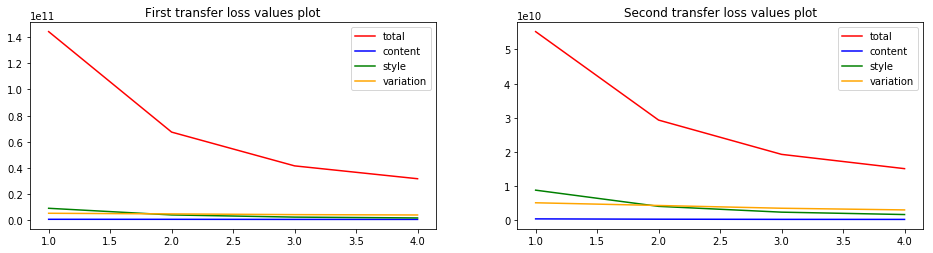

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(16, 3.8))

total_losses = [first_losses[i][0] for i in range(len(first_losses))]
content_losses = [first_losses[i][1] for i in range(len(first_losses))]
style_losses = [first_losses[i][2] for i in range(len(first_losses))]
variation_losses = [first_losses[i][3] for i in range(len(first_losses))]

axs[0].plot(range(1, len(first_losses) + 1), total_losses, color='red', label='total')
axs[0].plot(range(1, len(first_losses) + 1), content_losses, color='blue', label='content')
axs[0].plot(range(1, len(first_losses) + 1), style_losses, color='green', label='style')
axs[0].plot(range(1, len(first_losses) + 1), variation_losses, color='orange', label='variation')
axs[0].set_title("First transfer loss values plot")
axs[0].legend()

total_losses = [second_losses[i][0] for i in range(len(second_losses))]
content_losses = [second_losses[i][1] for i in range(len(second_losses))]
style_losses = [second_losses[i][2] for i in range(len(second_losses))]
variation_losses = [second_losses[i][3] for i in range(len(second_losses))]

axs[1].plot(range(1, len(second_losses) + 1), total_losses, color='red', label='total')
axs[1].plot(range(1, len(second_losses) + 1), content_losses, color='blue', label='content')
axs[1].plot(range(1, len(second_losses) + 1), style_losses, color='green', label='style')
axs[1].plot(range(1, len(second_losses) + 1), variation_losses, color='orange', label='variation')
axs[1].set_title("Second transfer loss values plot")
axs[1].legend()

plt.show()

## Obrazek bazowy i obrazek stylu

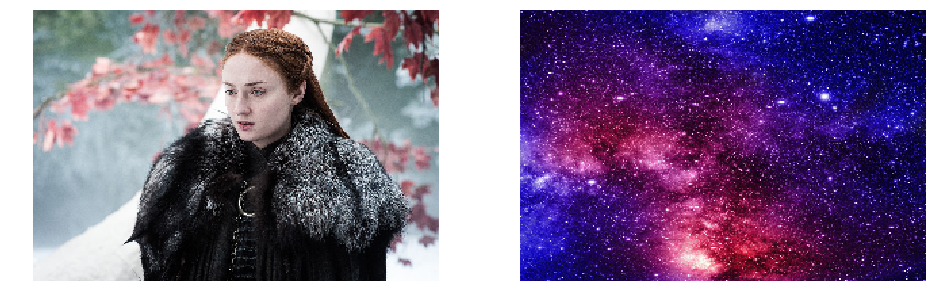

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
img_width = int(load_img(base_image_path).size[0] * generated_picture_height / load_img(base_image_path).size[1])

axs[0].imshow(load_img(base_image_path, target_size=(generated_picture_height, img_width)))
axs[0].axis('off')

axs[1].imshow(load_img(style_image_path, target_size=(generated_picture_height, img_width)))
axs[1].axis('off')

plt.show()

## Wyswietlenie wygenerowanych obrazkow

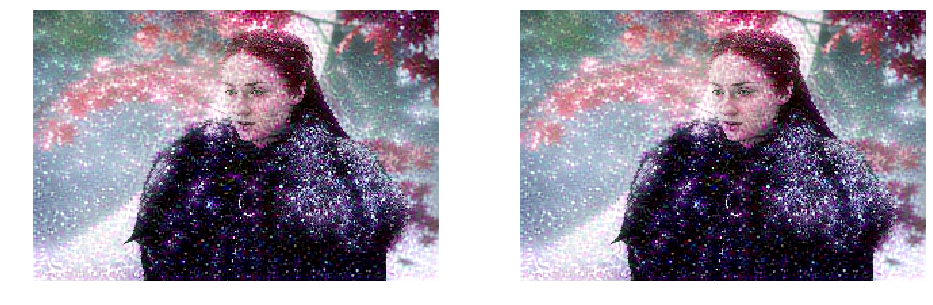

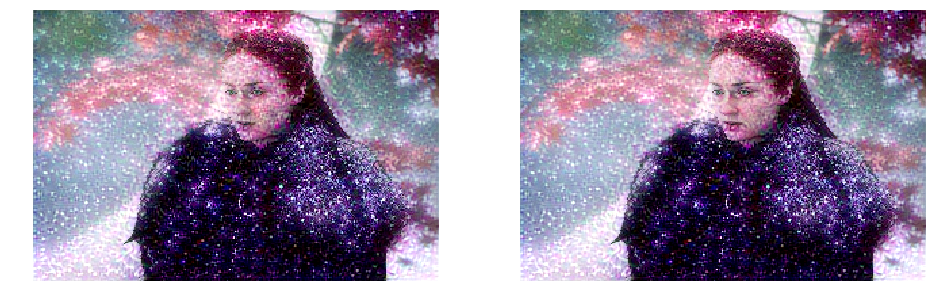

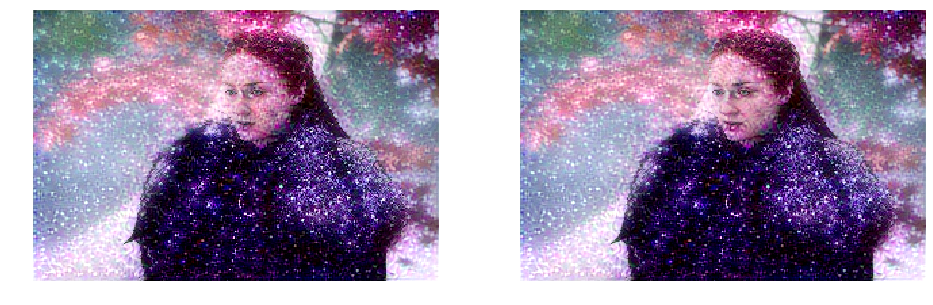

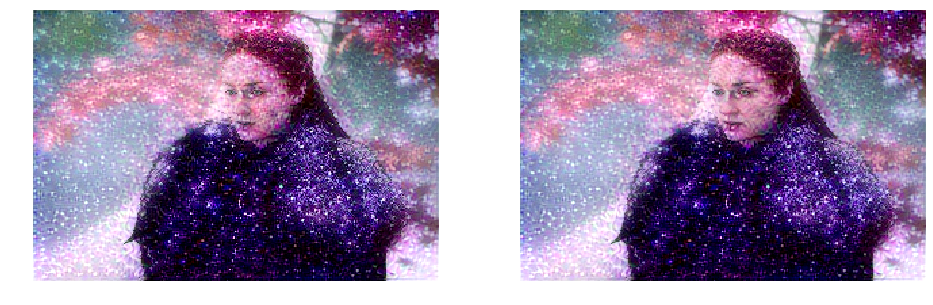

In [17]:
for img1, img2 in zip(first_images, second_images):
    fig, axs = plt.subplots(1, 2, figsize=(16, 5))

    axs[0].imshow(img1)
    axs[0].axis('off')
    
    axs[1].imshow(img2)
    axs[1].axis('off')
    
    plt.show()
    

In [ ]:
## TODO wizualizacja warstw

In [1]:
def visualize_layer(layer_number, layer_name, activations):
    # przygotowanie obrazu do wyswietlenia
    _, image_x, image_y, number_of_channels = activations.shape
    number_of_columns = 12
    number_of_rows = ceil(number_of_channels / number_of_columns)
    final_image = np.zeros((image_y * number_of_rows, image_x * number_of_columns))
    
    for channel_number in range(number_of_channels):
        (row, column) = (channel_number // number_of_columns, channel_number % number_of_columns)
        channel_activation = activations[0, :, :, channel_number]
        
        # normalizacja liczb do przedzialu [0, 1]
        channel_activation -= np.min(channel_activation)
        if np.max(channel_activation) != 0:
            channel_activation /= np.max(channel_activation)
            
        # podmiana czesci obbrazu do wyswietlenia na wizualizacje aktywacji kanalu
        final_image[
            row * image_y : (row + 1) * image_y, 
            column * image_x : (column + 1) * image_x
        ] = channel_activation
        
    plt.figure(figsize=(16, 30))
    plt.imshow(final_image, cmap="plasma")
    plt.title("Layer " + str(layer_number) + ": " + layer_name)
    plt.axis('off')
    plt.show()
    
def visualize_channels_activations(model, preprocessed_image, layers_to_visualize):    
    print("The given network contains", len(model.layers), "layers and",model.count_params() ,"parameters\n")
        
    for layer in layers_to_visualize:
        get_activations = k.function([model.layers[0].input], [model.layers[layer].output])
        activations = get_activations([preprocessed_image])
        visualize_layer(layer, model.layers[layer].name, activations[0])

In [ ]:


model = vgg19.VGG19(input_tensor=input_tensor, weights='imagenet', include_top=False)

visualize_channels_activations(model, preprocessed_image, layers_to_visualize=[1, 2, 3, 4, 5, 40, 120, 154])